### **Deep Learning with Pytorch: Image Segmentation**   
<!-- ##### Author: **Surya Teja Darisi** -->

#### Key Points about the Project <ul>
<li> Image segmentation in deep learning is a computer vision technique that divides an image into multiple segments or regions, assigning a label to each pixel based on its characteristics. This allows for a more detailed understanding of the image content, going beyond simple object detection by providing pixel-level information.
<li> Deep Learning models like U-Net are commonly used for this purpose, which we also used here.
<li> Image -> U-NET -> Masked Image (For example, locates humans)
<li> In a masked image, White Region - Label 1 (points sth). Black Region - Label 0
</ul>

If using a Colab, use GPU.

<!-- 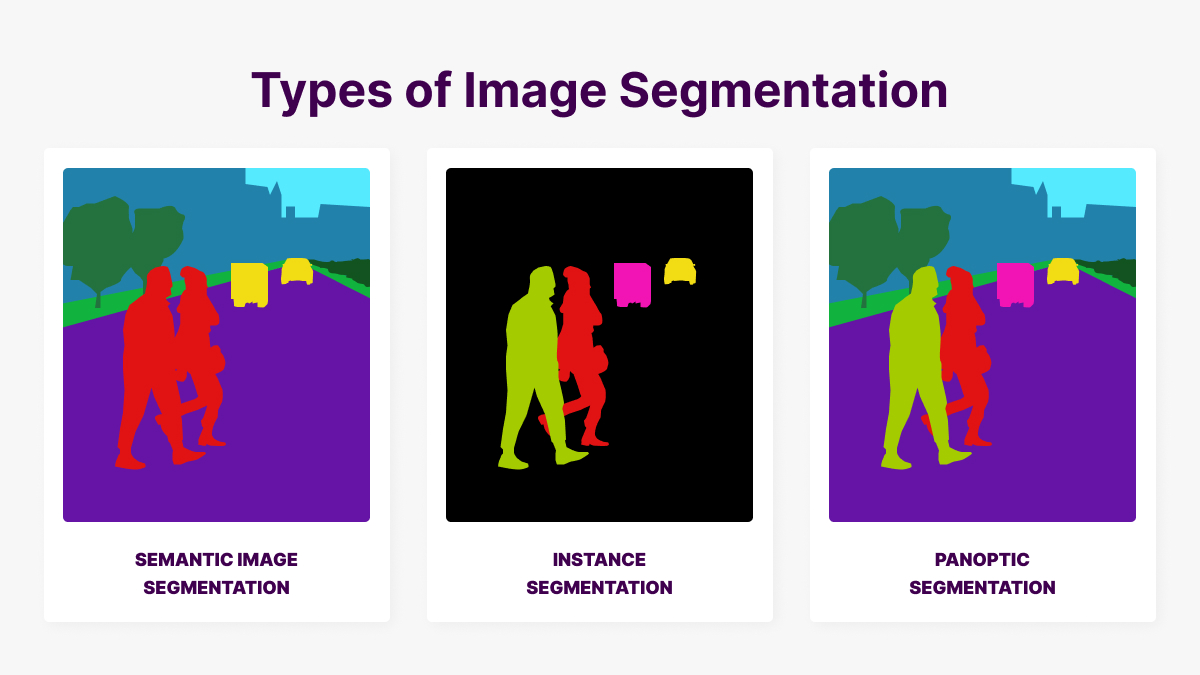 -->
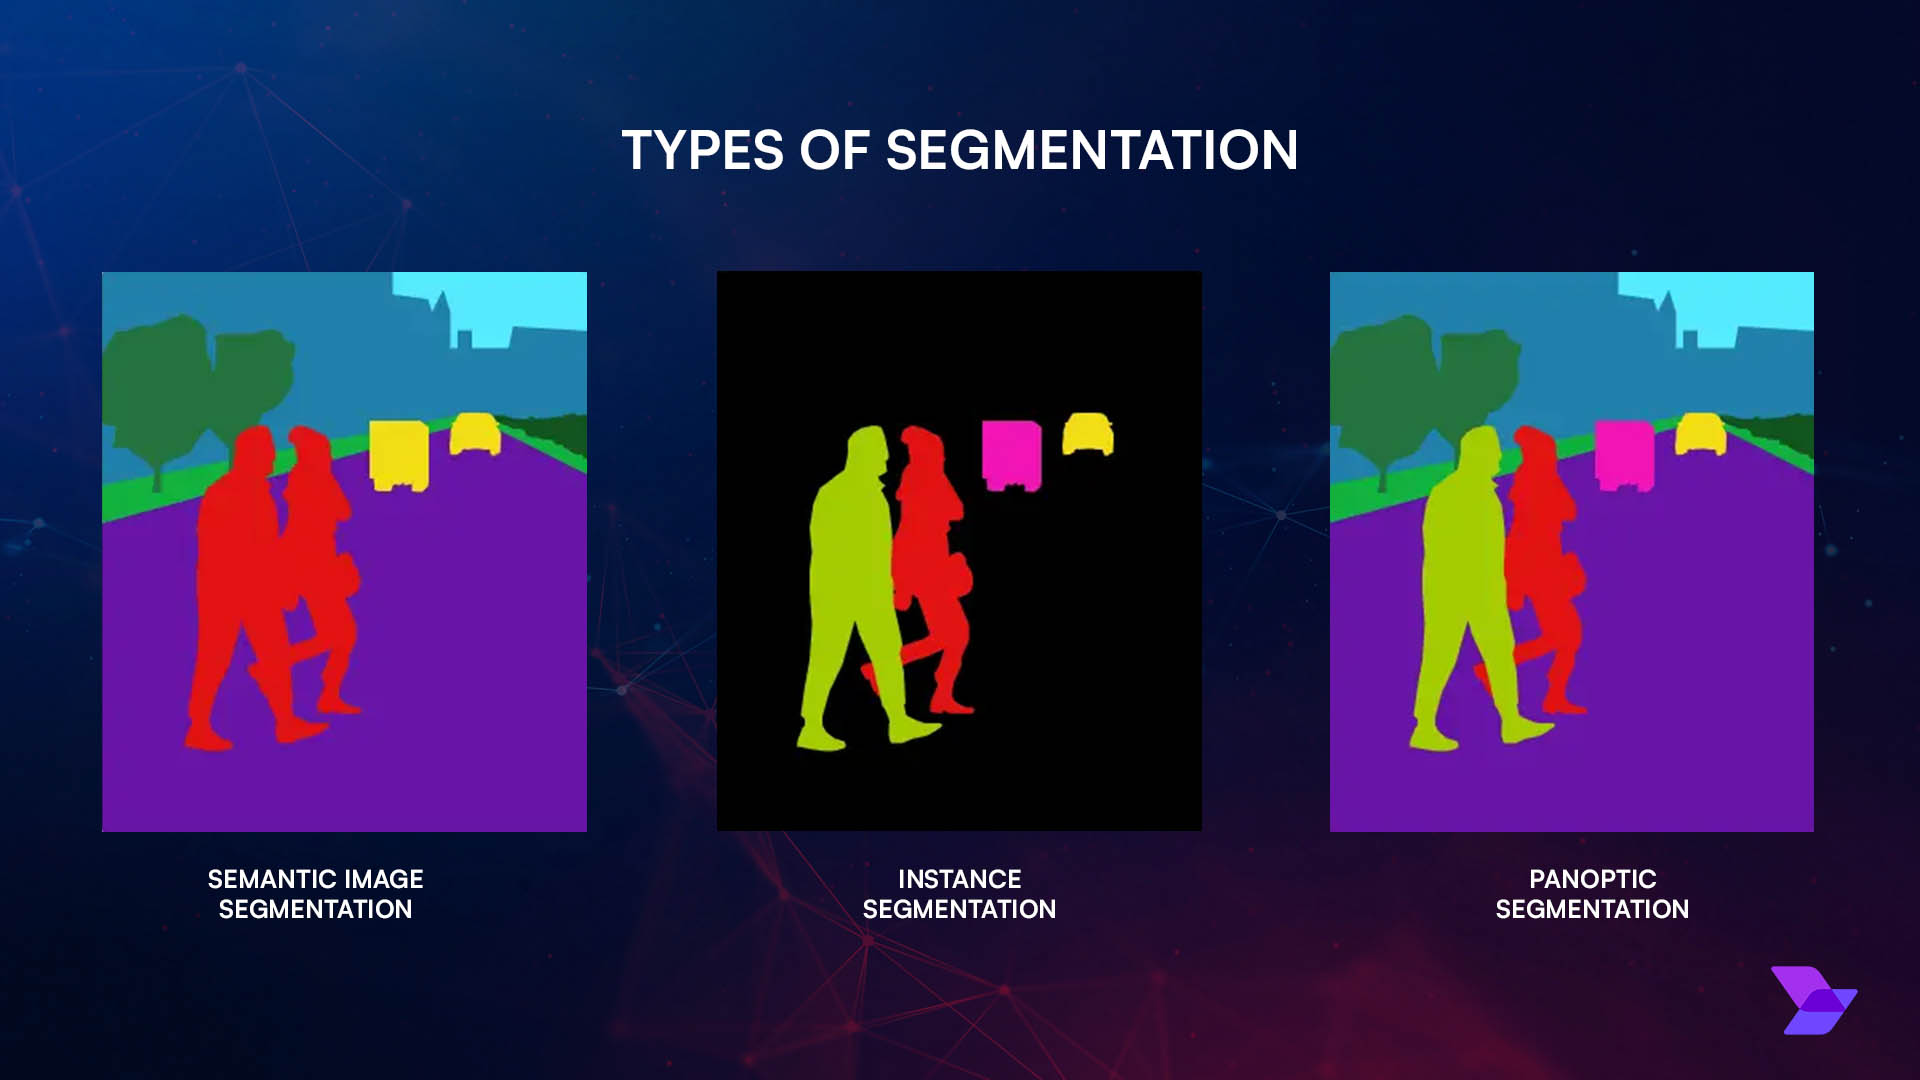

In [3]:
# To Download the Dataset 
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn
import cv2
import torch

In [105]:
FILE = 'Human-Segmentation-Dataset-master/train.csv'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 25
LR = 0.03
BATCH_SIZE = 16
IMAGE_SIZE = 320

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(FILE)
df

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
285,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
287,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
288,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


Link for OpenCV Tutorial from GFG  
https://www.geeksforgeeks.org/python/opencv-overview/

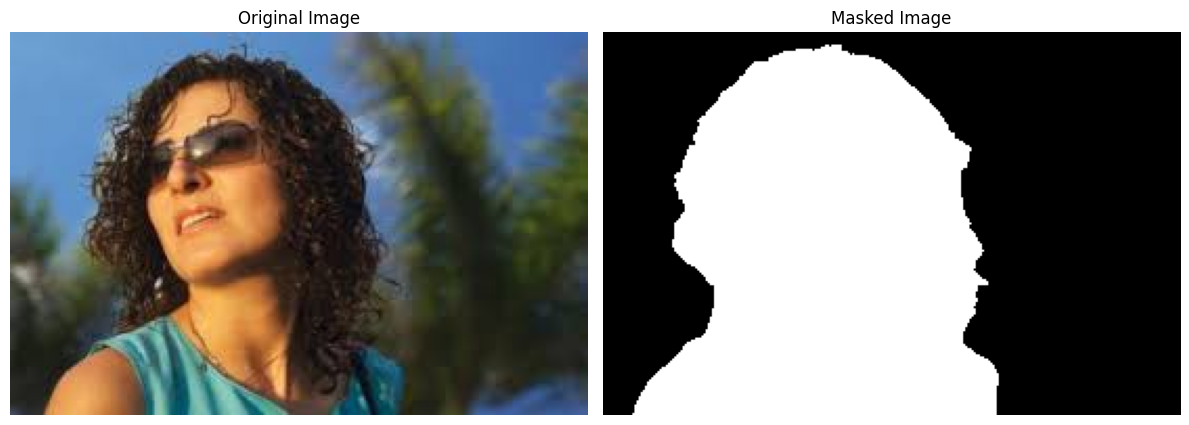

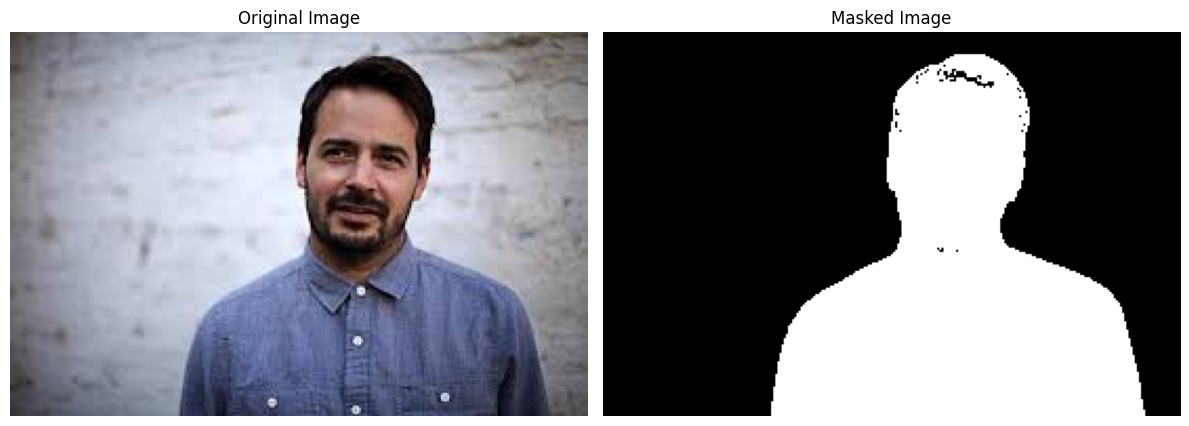

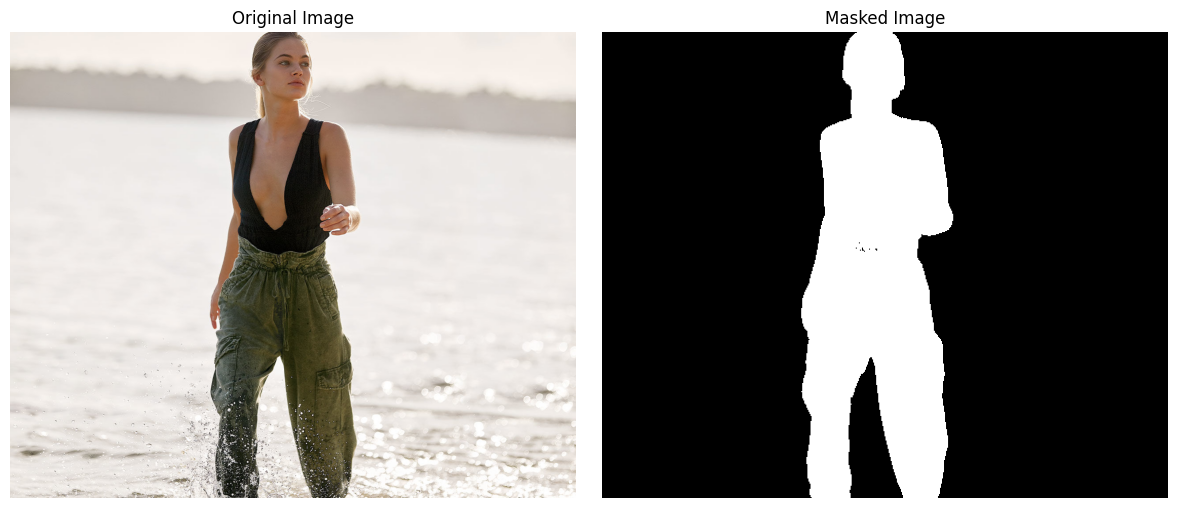

In [9]:
for i in range(3):
    plt.figure(figsize=(12,5))

    img = cv2.imread(df.iloc[i]['images'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1) # no of rows, cols, loc
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    masked_img = cv2.imread(df.iloc[i]['masks'])
    masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,2) # no of rows, cols, loc
    plt.imshow(masked_img)
    plt.title("Masked Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
train, valid = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
print(train.shape)
print(valid.shape)

(232, 2)
(58, 2)


### Augmentation  
Augmentation refers to a technique of artificially expanding the training dataset by applying various transformations to the original images. This helps improve the model's ability to generalize and perform well on unseen data by exposing it to a wider range of variations.   
For Image segmentation tasks, we apply augmentation only on images but not on labels.  
For example, in tasks like detection, if our image rotates by 45deg, the label still remains the same. But in segementation the masked image also rotates by 45deg.

In [17]:
import tqdm
import albumentations as alb

In [61]:
def get_train_aug():
    return alb.Compose([
        alb.Resize(IMAGE_SIZE, IMAGE_SIZE),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5)
    ])

def get_valid_aug():
    return alb.Compose([
        alb.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ])

In [62]:
import torch
from torch.utils.data import Dataset
# import grp
import helper

In [84]:
class SegmentationDataset(Dataset):
    def __init__(self,df,augmentations):
        self.df=df
        self.augmentations=augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)


        if self.augmentations:
            data = self.augmentations(image=img, mask=mask)
            img = data['image']
            mask = data['mask']

        img = np.transpose(img, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        img = torch.Tensor(img) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return img, mask

In [85]:
trainset = SegmentationDataset(train, get_train_aug())
validset = SegmentationDataset(valid, get_valid_aug())

In [119]:
import torchvision.transforms as T

def imshow_tensor(tensor, title=None):
    if tensor.ndimension() == 4:
        tensor = tensor[0]  # take first image in batch
    image = tensor.clone().detach()
    image = T.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

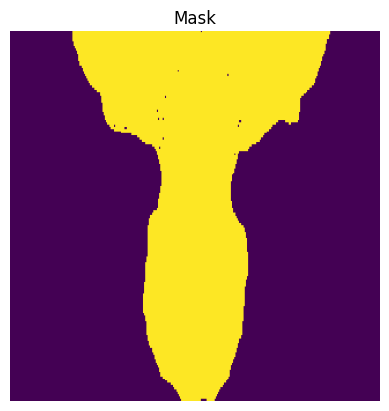

In [87]:
idx = 32
image, mask = trainset[idx]
# imshow_tensor(image, "Image")
imshow_tensor(mask, "Mask")

In [88]:
from torch.utils.data import DataLoader

In [89]:
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = DataLoader(validset, batch_size=BATCH_SIZE)

In [90]:
print(f"Total No. of batches in Train Loader = {len(trainLoader)}")
print(f"Total No. of batches in Valid Loader = {len(validLoader)}")

Total No. of batches in Train Loader = 15
Total No. of batches in Valid Loader = 4


In [91]:
for img, mask in trainLoader:
    break

print (f"One batch image shape: {img.shape}")
print(f"One batch mask size: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask size: torch.Size([16, 1, 320, 320])


### Segmentation Model

In [93]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [94]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet (
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward (self, images, masks=None):
        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits,masks)
            loss2 = nn.BCEWithLogitsLoss()(logits,masks)
            return logits, loss1+loss2
        
        return logits

In [106]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

In [113]:
from tqdm import tqdm

In [114]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss=0.0

    for images, masks in tqdm(data_loader):
        images=images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [115]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss=0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images=images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [116]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [117]:
best_valid_loss = np.inf
for i in range (EPOCHS):
    train_loss = train_fn(trainLoader, model, optimizer)
    valid_loss = eval_fn(validLoader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved Model")
        best_valid_loss=valid_loss

    print(f"Epoch: {i+1}")
    print(f"Train Loss: {train_loss}")
    print(f"Valid Loss: {valid_loss}")

100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Saved Model
Epoch: 1
Train Loss: 1.2185999552408855
Valid Loss: 13286.9853515625


100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


Saved Model
Epoch: 2
Train Loss: 0.9656008362770081
Valid Loss: 31.41175079345703


100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


Saved Model
Epoch: 3
Train Loss: 0.8983434597651164
Valid Loss: 7.2932634353637695


100%|██████████| 4/4 [00:16<00:00,  4.11s/it]


Saved Model
Epoch: 4
Train Loss: 0.8424229502677918
Valid Loss: 1.1497630178928375


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Saved Model
Epoch: 5
Train Loss: 0.8160870830217998
Valid Loss: 0.9168369024991989


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Saved Model
Epoch: 6
Train Loss: 0.752339486281077
Valid Loss: 0.8083981722593307


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch: 7
Train Loss: 0.7569002230962117
Valid Loss: 0.8197590261697769


100%|██████████| 4/4 [00:22<00:00,  5.56s/it]


Epoch: 8
Train Loss: 0.7456515947977702
Valid Loss: 0.8980185985565186


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch: 9
Train Loss: 0.7390736937522888
Valid Loss: 0.9466343224048615


100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Epoch: 10
Train Loss: 0.7068361282348633
Valid Loss: 1.4401558637619019


100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch: 11
Train Loss: 0.7245113213857015
Valid Loss: 0.8894156664609909


100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch: 12
Train Loss: 0.6971563498179117
Valid Loss: 1.2219515889883041


100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Saved Model
Epoch: 13
Train Loss: 0.6471633950869242
Valid Loss: 0.7442812919616699


100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch: 14
Train Loss: 0.6485187411308289
Valid Loss: 0.9189576059579849


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Saved Model
Epoch: 15
Train Loss: 0.6260877450307211
Valid Loss: 0.6458581238985062


100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Epoch: 16
Train Loss: 0.6484583854675293
Valid Loss: 0.8084664344787598


100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch: 17
Train Loss: 0.6137024164199829
Valid Loss: 0.7684411555528641


100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Saved Model
Epoch: 18
Train Loss: 0.6161941925684611
Valid Loss: 0.6454477906227112


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch: 19
Train Loss: 0.6359902421633402
Valid Loss: 0.8067885935306549


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch: 20
Train Loss: 0.556307605902354
Valid Loss: 0.9281986653804779


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Saved Model
Epoch: 21
Train Loss: 0.53206005692482
Valid Loss: 0.5983651578426361


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


Saved Model
Epoch: 22
Train Loss: 0.5410058975219727
Valid Loss: 0.5961080193519592


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch: 23
Train Loss: 0.5441310246785481
Valid Loss: 0.6604015454649925


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch: 24
Train Loss: 0.4966355462869008
Valid Loss: 0.7311594933271408


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

Saved Model
Epoch: 25
Train Loss: 0.5630741794904073
Valid Loss: 0.5717490091919899


In [139]:
idx = 2
model.load_state_dict(torch.load('best_model.pt'))
image , mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) --> (1, H, C, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

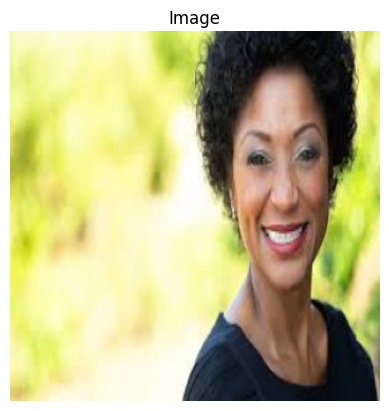

In [140]:
imshow_tensor(image, "Image") 

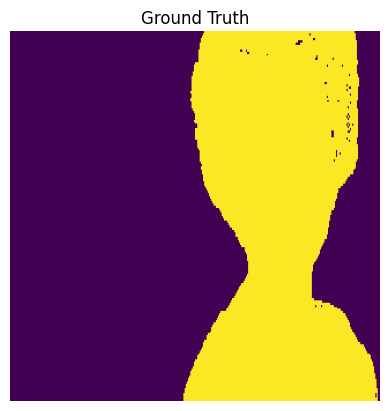

In [141]:
imshow_tensor(mask, "Ground Truth")

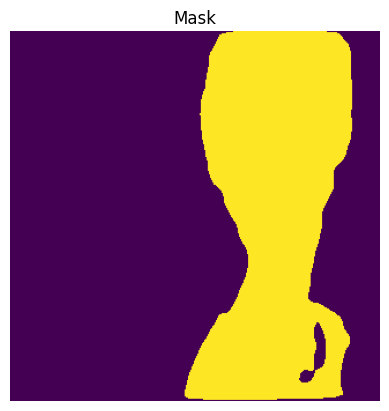

In [142]:
imshow_tensor(pred_mask.detach().cpu().squeeze(0), "Mask")